# Question A2 (10 marks)

### In this question, we will determine the optimal batch size for mini-batch gradient descent. Find the optimal batch size for mini-batch gradient descent by training the neural network and evaluating the performances for different batch sizes. Note: Use 5-fold cross-validation on training partition to perform hyperparameter selection. You will have to reconsider the scaling of the dataset during the 5-fold cross validation.

* note: some cells are non-editable and cannot be filled, but leave them untouched. Fill up only cells which are provided.

#### Plot mean cross-validation accuracies on the final epoch for different batch sizes as a scatter plot. Limit search space to batch sizes {128, 256, 512, 1024}. Next, create a table of time taken to train the network on the last epoch against different batch sizes. Finally, select the optimal batch size and state a reason for your selection.

This might take a while to run, so plan your time carefully.

In [1]:
import tqdm
import time
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from scipy.io import wavfile as wav

from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix

from common_utils import set_seed

# setting seed
set_seed()

2. To reduce repeated code, place your

- network (MLP defined in QA1)
- torch datasets (CustomDataset defined in QA1)
- loss function (loss_fn defined in QA1)

in a separate file called **common_utils.py**

Import them into this file. You will not be repenalised for any error in QA1 here as the code in QA1 will not be remarked.

The following code cell will not be marked.

In [2]:
# YOUR CODE HERE
from sklearn.preprocessing import StandardScaler, LabelEncoder
df = pd.read_csv('simplified.csv')
df['label'] = df['filename'].str.split('_').str[-2]

df['label'].value_counts()
def preprocess_data(df):
    X = df.drop(columns=['filename', 'label']).values
    y = df['label'].values

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)

    return X_scaled, y_encoded

X_train, y_train = preprocess_data(df)

from common_utils import MLP, CustomDataset, loss_fn
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

3. Define different folds for different batch sizes to get a dictionary of training and validation datasets. Preprocess your datasets accordingly.

In [4]:
def generate_cv_folds_for_batch_sizes(parameters, X_train, y_train):


    """
    returns:
    X_train_scaled_dict(dict) where X_train_scaled_dict[batch_size] is a list of the preprocessed training matrix for the different folds.
    X_val_scaled_dict(dict) where X_val_scaled_dict[batch_size] is a list of the processed validation matrix for the different folds.
    y_train_dict(dict) where y_train_dict[batch_size] is a list of labels for the different folds
    y_val_dict(dict) where y_val_dict[batch_size] is a list of labels for the different folds
    """
    # YOUR CODE HERE
    X_train_scaled_dict = {}
    X_val_scaled_dict = {}
    y_train_dict = {}
    y_val_dict = {}
    time_taken_dict = {}

    for batch_size in parameters:
        X_train_scaled_folds = []
        X_val_scaled_folds = []
        y_train_folds = []
        y_val_folds = []
        times = []

        kf = KFold(n_splits=5, shuffle=True, random_state=42)
        for train_index, val_index in kf.split(X_train):
            X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
            y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

            scaler = StandardScaler()
            X_train_fold_scaled = scaler.fit_transform(X_train_fold)
            X_val_fold_scaled = scaler.transform(X_val_fold)

            X_train_scaled_folds.append(X_train_fold_scaled)
            X_val_scaled_folds.append(X_val_fold_scaled)
            y_train_folds.append(y_train_fold)
            y_val_folds.append(y_val_fold)

            start_time = time.time()
            model = MLP(no_features=X_train_fold.shape[1], no_hidden=128, no_labels=1)
            optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
            criterion = nn.BCEWithLogitsLoss()

            for epoch in range(100):
                total_loss = 0
                model.train()
                for batch_idx in range(0, len(X_train_fold_scaled), batch_size):
                    inputs = torch.tensor(X_train_fold_scaled[batch_idx:batch_idx+batch_size], dtype=torch.float32)
                    labels = torch.tensor(y_train_fold[batch_idx:batch_idx+batch_size], dtype=torch.float32)
                    optimizer.zero_grad()
                    outputs = model(inputs)
                    loss = criterion(outputs, labels.view(-1, 1))
                    loss.backward()
                    optimizer.step()
                    total_loss += loss.item()

                avg_loss = total_loss / len(X_train_fold_scaled)

            end_time = time.time()
            times.append(end_time - start_time)

        X_train_scaled_dict[batch_size] = X_train_scaled_folds
        X_val_scaled_dict[batch_size] = X_val_scaled_folds
        y_train_dict[batch_size] = y_train_folds
        y_val_dict[batch_size] = y_val_folds
        time_taken_dict[batch_size] = np.mean(times)

    return X_train_scaled_dict, X_val_scaled_dict, y_train_dict, y_val_dict, time_taken_dict


batch_sizes = [128, 256, 512, 1024]
X_train_scaled_dict, X_val_scaled_dict, y_train_dict, y_val_dict, time_taken_dict = generate_cv_folds_for_batch_sizes(batch_sizes, X_train, y_train)

4. Perform hyperparameter tuning for the different batch sizes with 5-fold cross validation.

In [5]:
from sklearn.metrics import accuracy_score

def find_optimal_batch_size(X_train_scaled_dict, y_train_dict, X_val_scaled_dict, y_val_dict, batch_sizes):
    cross_validation_accuracies = []
    cross_validation_f1_scores = []
    training_times = []

    for batch_size in batch_sizes:
        avg_accuracy = 0
        avg_f1_score = 0
        avg_time = 0

        for fold in range(5):
            X_train_fold = X_train_scaled_dict[batch_size][fold]
            y_train_fold = y_train_dict[batch_size][fold]
            X_val_fold = X_val_scaled_dict[batch_size][fold]
            y_val_fold = y_val_dict[batch_size][fold]

            train_dataset = CustomDataset(X_train_fold, y_train_fold)
            val_dataset = CustomDataset(X_val_fold, y_val_fold)
            train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
            val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

            model = MLP(no_features=X_train_fold.shape[1], no_hidden=128, no_labels=1)  
            optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  

            # Train the model
            start_time = time.time()
            for epoch in range(100):
                total_loss = 0
                model.train()
                for batch in train_dataloader:
                    inputs, labels = batch
                    optimizer.zero_grad()
                    outputs = model(inputs)
                    loss = loss_fn(outputs, labels.view(-1, 1))
                    loss.backward()
                    optimizer.step()
                    total_loss += loss.item()

                avg_loss = total_loss / len(train_dataloader)

            end_time = time.time()
            avg_time += end_time - start_time

            # Evaluate accuracy and F1-score on validation set
            model.eval()
            val_accuracy = 0
            
            predictions = []
            with torch.no_grad():
                for batch in val_dataloader:
                    val_inputs, val_labels = batch
                    val_outputs = model(val_inputs)
                    val_predictions = (torch.sigmoid(val_outputs) >= 0.5).float()
                    predictions.extend(val_predictions.cpu().numpy())
                    val_accuracy += accuracy_score(val_labels.cpu().numpy(), val_predictions.cpu().numpy())
                    
            val_accuracy /= len(val_dataloader)
            avg_accuracy += val_accuracy

        avg_accuracy /= 5
        avg_time /= 5

        cross_validation_accuracies.append(avg_accuracy)
        training_times.append(avg_time)

        print(f'Batch Size: {batch_size}, Mean Cross-Validation Accuracy: {avg_accuracy:.4f}, Mean Training Time: {avg_time:.2f} seconds')

    return cross_validation_accuracies, training_times

batch_sizes = [128, 256, 512, 1024]
cross_validation_accuracies, training_times = find_optimal_batch_size(X_train_scaled_dict, y_train_dict, X_val_scaled_dict, y_val_dict, batch_sizes)

Batch Size: 128, Mean Cross-Validation Accuracy: 0.5145, Mean Training Time: 29.53 seconds
Batch Size: 256, Mean Cross-Validation Accuracy: 0.5152, Mean Training Time: 20.23 seconds
Batch Size: 512, Mean Cross-Validation Accuracy: 0.5141, Mean Training Time: 16.21 seconds
Batch Size: 1024, Mean Cross-Validation Accuracy: 0.5132, Mean Training Time: 15.99 seconds


5. Plot scatterplot of mean cross validation accuracies for the different batch sizes.

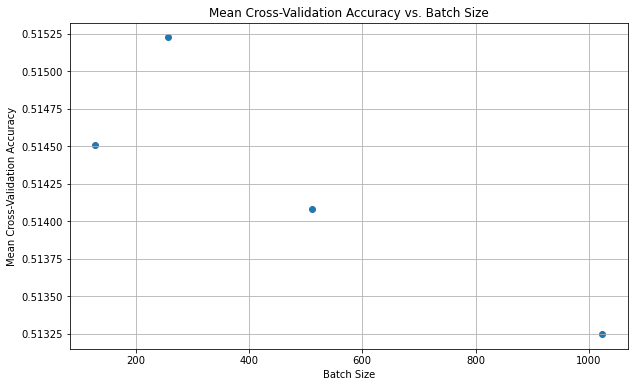

In [6]:
# YOUR CODE HERE
plt.figure(figsize=(10, 6))
plt.scatter(batch_sizes, cross_validation_accuracies)
plt.xlabel('Batch Size')
plt.ylabel('Mean Cross-Validation Accuracy')
plt.title('Mean Cross-Validation Accuracy vs. Batch Size')
plt.grid(True)
plt.show()

6. Create a table of time taken to train the network on the last epoch against different batch sizes. Select the optimal batch size and state a reason for your selection.

In [7]:
batch_time_df = pd.DataFrame({'Batch Size': batch_sizes, 'Training Time (seconds)': training_times})
print(batch_time_df)

   Batch Size  Training Time (seconds)
0         128                29.527876
1         256                20.233913
2         512                16.209294
3        1024                15.994007


In [8]:
# YOUR CODE HERE
optimal_batch_size = 256
reason = "The batch size of 256 has the highest mean cross-validation accuracy while still maintaining a reasonable training time. Therefore, 256 can be selected as the optimal batch size for your model."